In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import json
import argparse
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# set configs
def configs():
    parser = argparse.ArgumentParser()
    
    parser.add_argument("--batch_size", default=64)
    parser.add_argument("--lr", default=0.02)
    parser.add_argument("--epochs", default=20)
    parser.add_argument("--test", default=False)
    parser.add_argument("--resume", default=False)
    parser.add_argument("--model_path", default="output/model_final.pth")
    parser.add_argument("--record_path", default="output/record.json")
    parser.add_argument("--device", default=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))
    parser.add_argument("--parallel" ,default=True)
    parser.add_argument("--device_id", default=[0,1,2,3])

    args = parser.parse_args(args=[])
    return args
    

In [3]:
# load dataset
def dataloader(args):
    data_ft = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

    train_dataset = datasets.MNIST("./data", train=True, transform=data_ft, download=True)
    test_dataset = datasets.MNIST("./data", train=False, transform=data_ft)

    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)
    return train_loader, test_loader

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128*4*4, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 10),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)

        return x

In [5]:
def eval(args, model, test_loader):
    
    correct = 0
    total = 0

    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(args.device), labels.to(args.device)
        with torch.no_grad():
            outputs = model(inputs)
            _, pred = torch.max(outputs, 1)
            correct += (labels == pred).sum()
            total += labels.size()[0]
    acc = correct.item() / total
    
    return acc

In [6]:
def train(args, train_loader, test_loader):
    model = Net()
    if args.parallel:
        model = nn.DataParallel(model, device_ids=args.device_id)
        
    # test mode
    if args.test:   
        model.load_state_dict(torch.load(args.model_path))
        model.to(args.device)
        model.eval()
        acc = eval(args, model, test_loader)
        print("acc: %.2f" % acc)
        return model
        
    # train mode
    start_epoch = 1
    record = {}
    loss_history = []

    if args.resume:
        model.load_state_dict(torch.load(args.model_path))
        with open(args.record_path, 'r') as f:
            data = json.load(f)
            loss_history = data['loss_history']
            start_epoch = data['last_epoch']+1
            f.close()

    model.to(args.device)
    criterion = nn.CrossEntropyLoss()
    optimiser = optim.SGD(model.parameters(), lr=args.lr)

    for epoch in range(start_epoch, args.epochs+1):
        epoch_loss = 0
        for _, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(args.device), labels.to(args.device)
            optimiser.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimiser.step()
            epoch_loss += loss.item()
        loss_history.append(epoch_loss)
        print("epoch: %4d  loss: %.4f\n" % (epoch, epoch_loss)) 
    torch.save(model.state_dict(), args.model_path)

    acc = eval(args, model, test_loader)
    print("acc: %.4f\n" % acc)

    # write to json files
    record['loss_history'] = loss_history
    record['acc'] = acc
    record['last_epoch'] = len(loss_history)
    with open(args.record_path, 'w') as f:
            json.dump(record, f)
            f.close()
    
    return model

In [7]:
# draw
def draw(args):
    with open(args.record_path, 'r') as f:
        record = json.load(f)
        f.close()
    x = [i for i in range(1, record['last_epoch']+1)]
    plt.plot(x, record['loss_history'])
    plt.title("loss history")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()

epoch:    1  loss: 211.5760

epoch:    2  loss: 46.6767

epoch:    3  loss: 31.9768

epoch:    4  loss: 24.2913

epoch:    5  loss: 19.4359

epoch:    6  loss: 15.7794

epoch:    7  loss: 12.6410

epoch:    8  loss: 9.2398

epoch:    9  loss: 7.8637

epoch:   10  loss: 5.9538

epoch:   11  loss: 4.6398

epoch:   12  loss: 3.7255

epoch:   13  loss: 2.6681

epoch:   14  loss: 2.2433

epoch:   15  loss: 1.7286

epoch:   16  loss: 1.5601

epoch:   17  loss: 1.3913

epoch:   18  loss: 1.1474

epoch:   19  loss: 0.9936

epoch:   20  loss: 0.8865

acc: 0.9938



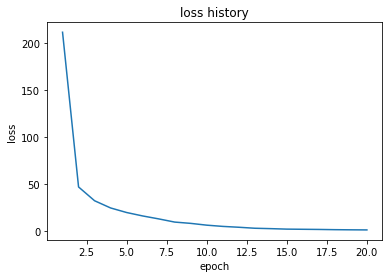

In [8]:
if __name__ == "__main__":
    args = configs()
    args.test = False
    args.resume = False
    
    train_loader, test_loader = dataloader(args)
    train(args, train_loader, test_loader)
    draw(args)